# SynFerm Exploratory Data Analysis
#### Targets:
- See some of the basic trends in the data (which BBs react well? which not at all?)
- perform basic statistics (How many successful reactions?)

#### Sections:
1. [Load and filter data](#1)
2. [Investigate "invalid" reactions](#2)
3. [General Statistics](#3)
4. [Building Block Statistics](#4)
5. [Trends within building block classes](#5)
6. [Scaling the LC-MS responses](#6)
7. [Outcome for the main product](#7)

In [1]:
import pathlib
import re
import sys
from typing import Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from rdkit.Chem.AllChem import Compute2DCoords
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, accuracy_score, balanced_accuracy_score, confusion_matrix, recall_score
%matplotlib inline

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection
from src.util.color_palette import BodeColorPalette
from src.util.pandas_utils import alphanumeric_index_sort

In [2]:
# settings
bode_palette = BodeColorPalette()
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['figure.dpi'] = 100  # this makes the figures bigger in jupyter nb

sns.set_theme(context="paper",
              style="white",
              font_scale=0.7,
              rc={"savefig.transparent": True,
                  "axes.grid": False,
                  "axes.spines.bottom": True,
                  "axes.spines.left": False,
                  "axes.spines.right": False,
                  "axes.spines.top": False,
                  "axes.labelweight": "bold",
                  },
             )
SAVE_DIR = pathlib.Path("/Users/julian/Desktop/SF_exploratory_data_analysis/")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

### Load and filter data <a id=1></a>

In [3]:
db = SynFermDatabaseConnection()  # we will use this for various simple queries

In [4]:
df_full = db.get_experiments_table_as_df()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 59944


### Select experiments for analysis

In [5]:
# show all available experiments with reaction counts
df_full["exp_nr"].value_counts().sort_index()

1        1920
2        1920
3        1920
4        1920
5        1920
6        1920
7        1920
8        1920
9        1920
10       1920
11       1920
12       1920
13       1920
14       1920
15       1920
16       1920
17       1920
18       1920
19       1920
20       1920
21       1920
22       1920
23       1920
24       1920
25       1920
26       1920
27       1920
28       1920
29       1920
100       320
101       960
99000     384
99001     648
99002     592
99003      16
99004     384
99005     960
Name: exp_nr, dtype: int64

In [6]:
# select experiment numbers for further analysis
start_exp_nr = 4  # kick out invalid experiments (SOP changed after exp3)
end_exp_nr = 29  # (inclusive)

df_full = df_full.loc[df_full['exp_nr'].between(start_exp_nr, end_exp_nr)]  
print(f'Number of reactions since SOP change and without test reactions: {len(df_full)}')

Number of reactions since SOP change and without test reactions: 49920


### Investigate "invalid" reactions <a id=2></a>

In [7]:
# expand the "valid" column to work with it more easily
# add columns for error and warning
df_full["has_error"] = df_full["valid"].notna() & df_full["valid"].str.contains("ERROR")
df_full["has_warning"] = df_full["valid"].notna() & df_full["valid"].str.contains("WARNING")
# add columns for error categories
df_full["has_error_product_peaks"] = df_full["valid"].notna() & df_full["valid"].str.contains("ERROR: multiple peaks for product A")
df_full["has_error_internal_standard"] = df_full["valid"].notna() & (
        df_full["valid"].str.contains("ERROR: IS response <50% of plate median")
        | df_full["valid"].str.contains("ERROR: multiple peaks for IS")
        | df_full["valid"].str.contains("ERROR: IS response >200% of plate median")
)
df_full["has_error_transfer"] = df_full["valid"].notna() & df_full["valid"].str.contains("transfer error")
df_full["has_error_low_volume"] = df_full["valid"].notna() & df_full["valid"].str.contains("ERROR: Dilution survey low volume")
df_full["has_error_other"] = df_full["valid"].notna() & (df_full["valid"].str.contains("ERROR: No monomer") | df_full["valid"].str.contains("ERROR: Monomer solution had lower concentration than required") )
df_full["has_warning_product_peaks"] = df_full["valid"].notna() & df_full["valid"].str.contains("WARNING: multiple peaks for product A")
df_full["has_warning_quality_control"] = df_full["valid"].notna() & df_full["valid"].str.contains("WARNING") & df_full["valid"].str.contains("QC")
df_full

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,valid,has_error,has_warning,has_error_product_peaks,has_error_internal_standard,has_error_transfer,has_error_low_volume,has_error_other,has_warning_product_peaks,has_warning_quality_control
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,WARNING: heating failure on first step; WARNIN...,False,True,False,False,False,False,False,True,False
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,WARNING: heating failure on first step; WARNIN...,False,True,False,False,False,False,False,True,False
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,WARNING: heating failure on first step; WARNIN...,False,True,False,False,False,False,False,True,False
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,WARNING: heating failure on first step; WARNIN...,False,True,False,False,False,False,False,True,False
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,WARNING: heating failure on first step; ERROR:...,True,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,WARNING: multiple peaks for product A (3),False,True,False,False,False,False,False,True,False
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,WARNING: multiple peaks for product A (3),False,True,False,False,False,False,False,True,False
85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,Mon020,...,None,False,False,False,False,False,False,False,False,False


In [8]:
df_full[[col for col in df_full.columns if col.startswith("has_")]].sum()

has_error                      10063
has_warning                    19622
has_error_product_peaks         1294
has_error_internal_standard     5801
has_error_transfer               852
has_error_low_volume             565
has_error_other                  179
has_warning_product_peaks      16717
has_warning_quality_control     1849
dtype: int64

In [9]:
# let's split this into the individual errors/warnings
expanded_warnings = df_full.loc[:,'valid'].str.split(";", expand=True)
expanded_warnings.columns = [f"problem_{i}" for i in expanded_warnings.columns]
df_full = df_full.join(expanded_warnings, how="left")
# sanitize
df_full.replace(' ', np.nan, inplace=True)  # replace whitespace strings with NaN (artifact from splitting)
df_full

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,has_error_low_volume,has_error_other,has_warning_product_peaks,has_warning_quality_control,problem_0,problem_1,problem_2,problem_3,problem_4,problem_5
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,False,False,True,False,WARNING: heating failure on first step,WARNING: multiple peaks for product A (2),None,None,None,None
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,False,False,True,False,WARNING: heating failure on first step,WARNING: multiple peaks for product A (2),None,None,None,None
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,False,False,True,False,WARNING: heating failure on first step,WARNING: multiple peaks for product A (2),None,None,None,None
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,False,False,True,False,WARNING: heating failure on first step,WARNING: multiple peaks for product A (2),None,None,None,None
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,False,False,False,False,WARNING: heating failure on first step,ERROR: multiple peaks for IS (43),ERROR: IS response <50% of plate median,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,False,False,True,False,WARNING: multiple peaks for product A (3),None,None,None,None,None
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,False,False,True,False,WARNING: multiple peaks for product A (3),None,None,None,None,None
85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,Mon020,...,False,False,False,False,None,None,None,None,None,None


In [10]:
# obtain IS areas from the database
res = db.con.execute("SELECT exp_nr, plate_nr, lcms_areas FROM experiments INNER JOIN lcms l on experiments.id = l.synthesis_id;").fetchall()
df_lcms_areas = pd.DataFrame(res, columns=["exp_nr", "plate_nr", "lcms_areas"])
df_lcms_areas["IS_area"] = df_lcms_areas["lcms_areas"].apply(lambda x: float(x.strip("[]").split(", ")[-1]))
df_lcms_areas

,exp_nr,plate_nr,lcms_areas,IS_area
0,1,4,"[80297.0, 45917.0, 0.0, 6151.0, 27041.0, 36964...",3452211.0
1,1,4,"[3319.0, 3430.0, 0.0, 5089.0, 119552.0, 127273...",3718167.0
2,1,4,"[220071.0, 12151.0, 0.0, 0.0, 0.0, 18899.0, 26...",3794573.0
3,1,4,"[43620.0, 101891.0, 0.0, 0.0, 0.0, 24746.0, 0....",4182385.0
4,1,4,"[1915179.0, 7389401.0, 7290.0, 130203.0, 40767...",34937820.0
...,...,...,...,...
59619,101,3,"[0.0, 0.0, 0.0, 9541.0, 0.0, 2934331.0, 110536...",29093533.0
59620,101,3,"[0.0, 0.0, 0.0, 11343.0, 0.0, 3513593.0, 19749...",31044332.0
59621,101,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 2923154.0, 241897.0,...",27447305.0
59622,101,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 2903105.0, 67983.0, ...",31886900.0


In [11]:
grouped = df_lcms_areas.groupby(["exp_nr", "plate_nr"])
df_lcms_is_mean = grouped.mean(numeric_only=True)
df_lcms_is_std = grouped.std(numeric_only=True)
df_lcms_is = df_lcms_is_mean.join(df_lcms_is_std, lsuffix="_mean", rsuffix="_std")
df_lcms_is = df_lcms_is.reset_index()
df_lcms_is["plate"] = df_lcms_is["exp_nr"] * 7 + df_lcms_is["plate_nr"]
df_lcms_is = df_lcms_is.loc[df_lcms_is["exp_nr"].between(4, 30)]

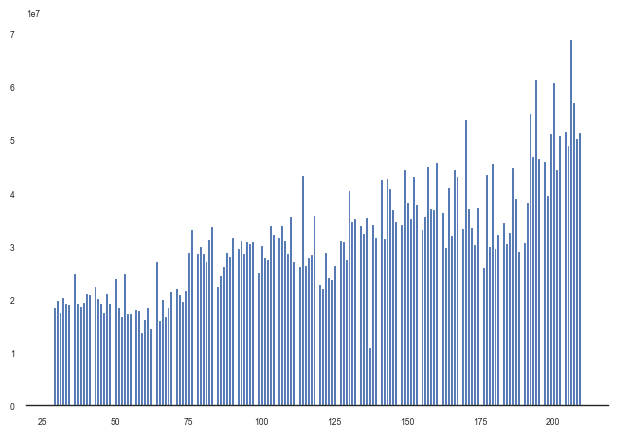

In [12]:
plt.figure(figsize=(7.5, 5))
plt.bar(
    x=df_lcms_is["plate"],
    height=df_lcms_is["IS_area_mean"],
    #yerr=df_lcms_is["IS_area_std"],
    width=1,

    )
plt.savefig(SAVE_DIR / "IS_areas.png", dpi=300)

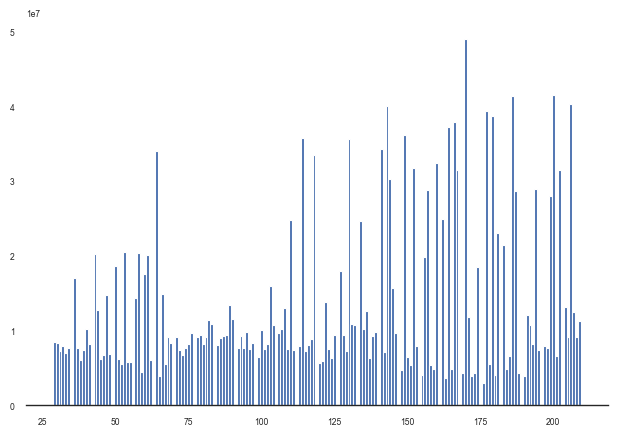

In [13]:
# plot the standard deviations
plt.figure(figsize=(7.5, 5))
plt.bar(
    x=df_lcms_is["plate"],
    height=df_lcms_is["IS_area_std"],
    #yerr=df_lcms_is["IS_area_std"],
    width=1,

    )
plt.savefig(SAVE_DIR / "IS_areas_std.png", dpi=300)

### Conclusion from IS response statistics
There is no clear trend in the IS response. The standard deviation is generally quite high.
I would have expected to see the SD increase with plate number within an experiment block, because that correlates with the age of the plate at measurement time, but we do not observe a trend like this.

In [14]:
# how many reactions have errors?
df_full.has_error.sum()

10063

In [15]:
# how many reactions have warnings?
df_full.has_warning.sum()

19622

In [16]:
# what are the most common problems?
df_full[[col for col in df_full.columns if col.startswith("problem_")]].stack().value_counts()

 ERROR: IS response <50% of plate median      4731
ERROR: multiple peaks for IS (2)              2032
                                             ...  
 ERROR: multiple peaks for IS (117)              1
 ERROR: multiple peaks for IS (19)               1
ERROR: multiple peaks for IS (126)               1
ERROR: multiple peaks for IS (136)               1
 ERROR: multiple peaks for IS (144)              1
Length: 383, dtype: int64

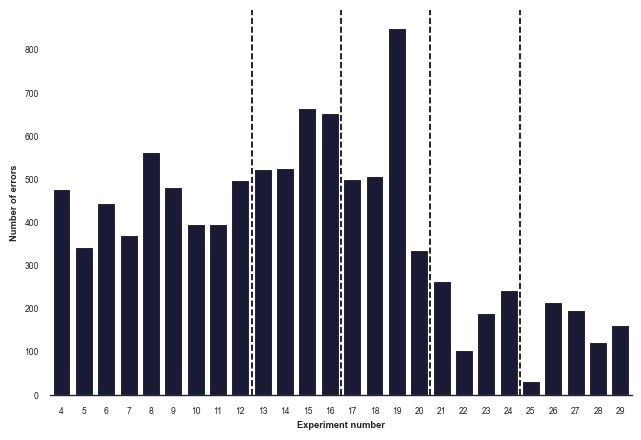

In [17]:
# Generate a histogram showing the distribution of errors across experiments
plt.figure(figsize=(7.5, 5))
sns.barplot(x=df_full.loc[df_full.has_error, "exp_nr"].value_counts().sort_index().index,
            y=df_full.loc[df_full.has_error, "exp_nr"].value_counts().sort_index().values,
            color=bode_palette.blue,
            )
plt.xlabel('Experiment number')
plt.ylabel('Number of errors')
plt.axvline(x=8.5, color="black", linestyle='--', label='Changed to OT2 source preparation before exp13')
plt.axvline(x=12.5, color="black", linestyle='--', label='Changed to full automation before exp17')
plt.axvline(x=16.5, color="black", linestyle='--', label='Changed to Eppendorf heat seal before exp21')
plt.axvline(x=20.5, color="black", linestyle='--', label='Changed to Agilent heat seal before exp21')
plt.savefig(SAVE_DIR / "number_of_errors_per_experiment.png", dpi=300, bbox_inches='tight')

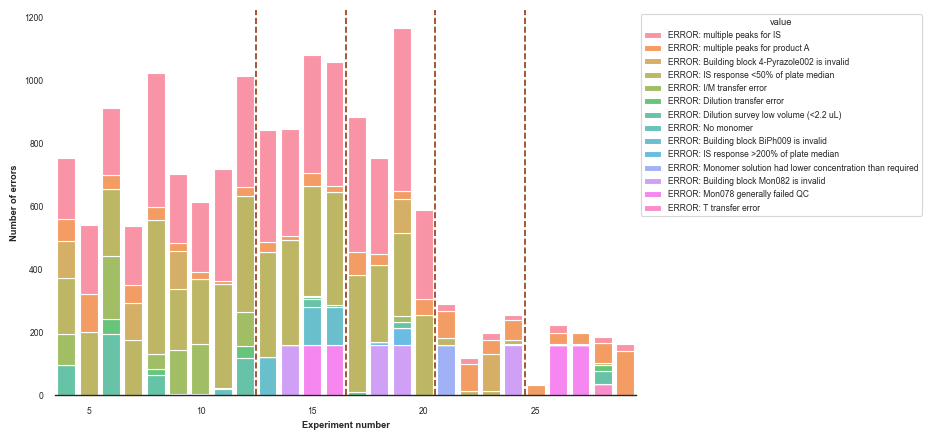

In [18]:
# Generate a histogram showing the distribution of errors across experiments
# Function to remove the value in parentheses
def remove_parentheses_value(s):
    if isinstance(s, str):
        return re.sub(r'\s\(\d+\)', '', s)
    return s


# Keep only the relevant columns
relevant_columns = ['exp_nr'] + [col for col in df_full.columns if 'problem_' in col]
df_relevant = df_full[relevant_columns].copy()

for col in relevant_columns:
    if col != 'exp_nr':
        df_relevant[col] = df_relevant[col].apply(remove_parentheses_value)
        df_relevant[col] = df_relevant[col].apply(lambda x: x.strip() if isinstance(x, str) else x)

# right now we are only interested in errors
df_relevant_errors = df_relevant.replace(re.compile('.*WARNING.*'), pd.NA)

# Melt the DataFrame
df_melted = pd.melt(df_relevant_errors, id_vars=['exp_nr'], var_name='columns', value_name='value')

# Filter out None values
df_filtered = df_melted[df_melted['value'].notnull()]

# Create the histogram
plt.figure(figsize=(7.5, 5))
ax = sns.histplot(data=df_filtered, x='exp_nr', hue='value', multiple='stack', discrete=True, shrink=.8)
plt.axvline(x=12.5, color=bode_palette.orange, linestyle='--', label='Changed to OT2 source preparation before exp13')
plt.axvline(x=16.5, color=bode_palette.orange, linestyle='--', label='Changed to full automation before exp17')
plt.axvline(x=20.5, color=bode_palette.orange, linestyle='--', label='Changed to Eppendorf heat seal before exp21')
plt.axvline(x=24.5, color=bode_palette.orange, linestyle='--', label='Changed to Agilent heat seal before exp25')
plt.xlim(3.5, 29.5)
plt.xlabel('Experiment number')
plt.ylabel('Number of errors')
# Move the legend outside the plot to the right
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(SAVE_DIR / "type_of_errors_per_experiment.png", dpi=300, bbox_inches='tight')

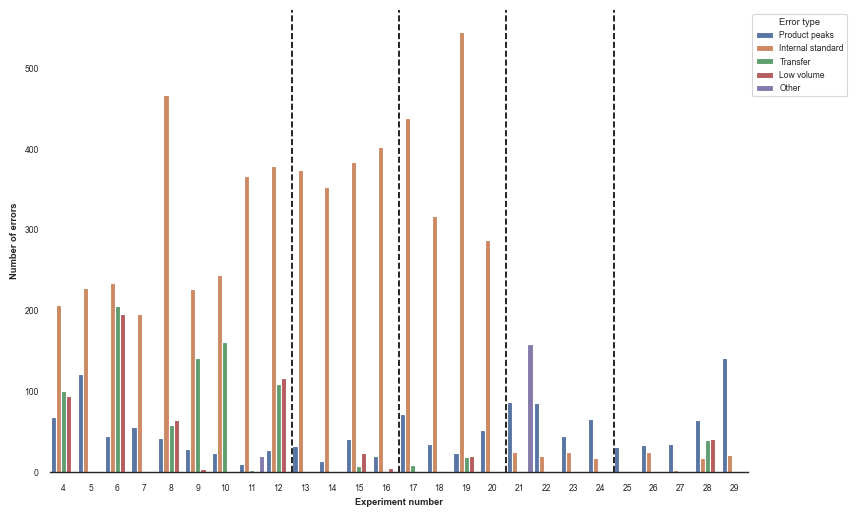

In [19]:
# Generate a histogram showing the distribution of errors across experiments, but use the error bins instead of the individual errors

# Keep only the relevant columns
relevant_columns = ['exp_nr'] + [col for col in df_full.columns if 'has_error_' in col]
df_relevant = df_full[relevant_columns].copy()

# Reshape the DataFrame
df_grouped = df_relevant.groupby('exp_nr').sum().reset_index().melt(id_vars=["exp_nr"], var_name="columns", value_name='value')
# Filter out None values
df_grouped = df_grouped[df_grouped['value'].notnull()]
# Plot the histogram
plt.figure(figsize=(9, 6))
ax = sns.barplot(data=df_grouped, x="exp_nr", y="value", hue='columns', dodge=True, width=.95)
plt.axvline(x=8.5, color="black", linestyle='--', label='Changed to OT2 source preparation before exp13')
plt.axvline(x=12.5, color="black", linestyle='--', label='Changed to full automation before exp17')
plt.axvline(x=16.5, color="black", linestyle='--', label='Changed to Eppendorf heat seal before exp21')
plt.axvline(x=20.5, color="black", linestyle='--', label='Changed to Agilent heat seal before exp25')
plt.xlabel('Experiment number')
plt.ylabel('Number of errors')
handles, labels = ax.get_legend_handles_labels()
ax.legend(title = "Error type", loc='upper left', bbox_to_anchor=(1, 1), handles=handles[4:], labels=[l.removeprefix("has_error_").replace("_", " ").strip().capitalize() for l in labels[4:]])
plt.savefig(SAVE_DIR / "type_of_errors_per_experiment_binned.png", dpi=300, bbox_inches='tight')


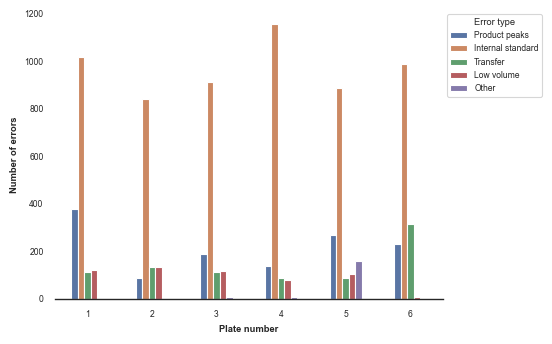

In [20]:
# next, we look at the distribution of errors by plate number within an experiment
# Keep only the relevant columns
relevant_columns = ['plate_nr'] + [col for col in df_full.columns if 'has_error_' in col]
df_relevant = df_full[relevant_columns].copy()
df_grouped = df_relevant.groupby('plate_nr').sum().reset_index().melt(id_vars=["plate_nr"], var_name="columns", value_name='value')
# Filter out None values
df_grouped = df_grouped[df_grouped['value'].notnull()]
# Plot the histogram
plt.figure(figsize=(5, 3.75))
ax = sns.barplot(data=df_grouped, x="plate_nr", y="value", hue='columns', dodge=True, width=.5)
plt.xlabel('Plate number')
plt.ylabel('Number of errors')
handles, labels = ax.get_legend_handles_labels()
ax.legend(title = "Error type", loc='upper left', bbox_to_anchor=(1, 1), handles=handles, labels=[l.removeprefix("has_error_").replace("_", " ").strip().capitalize() for l in labels])
plt.savefig(SAVE_DIR / "type_of_errors_per_plate_binned.png", dpi=300, bbox_inches='tight')

Let's have a look at the worst offenders. there might be a structural reason why they give multiple peaks in LCMS

In [21]:
x = df_full.loc[df_full['valid'].notna() & df_full['valid'].str.contains('multiple peaks for product A'), ['initiator']].value_counts()
x

initiator
I6           710
I22          639
I7           582
I3           570
I65          562
            ... 
I51           66
I68           62
I63           46
I74            9
I55            8
Length: 67, dtype: int64

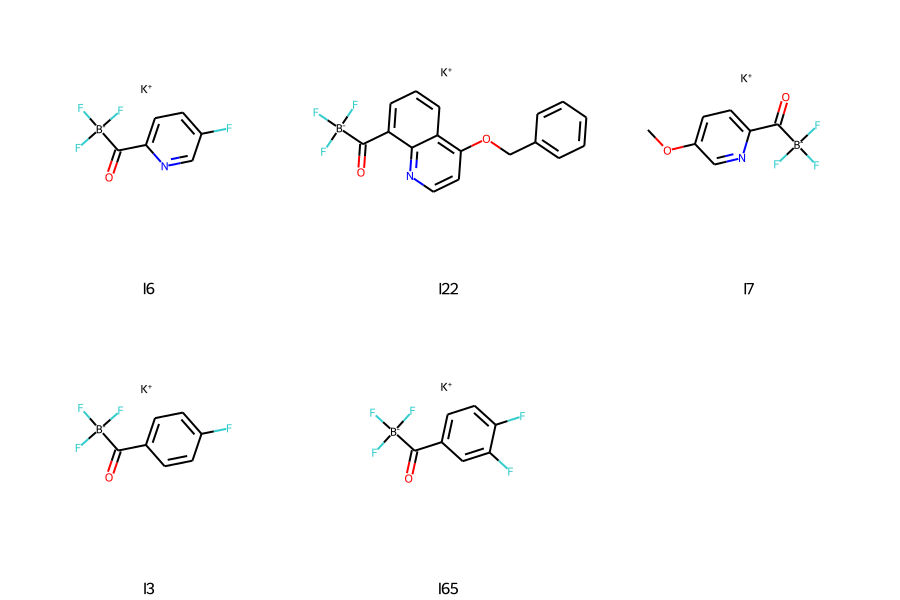

In [22]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [23]:
x = df_full.loc[df_full['valid'].notna() & df_full['valid'].str.contains('multiple peaks for product A'), ['monomer']].value_counts()
x

monomer
M2         659
M1         611
M52        585
M72        572
M51        528
          ... 
M65         91
M12         88
M36         46
M58         27
M27          6
Length: 72, dtype: int64

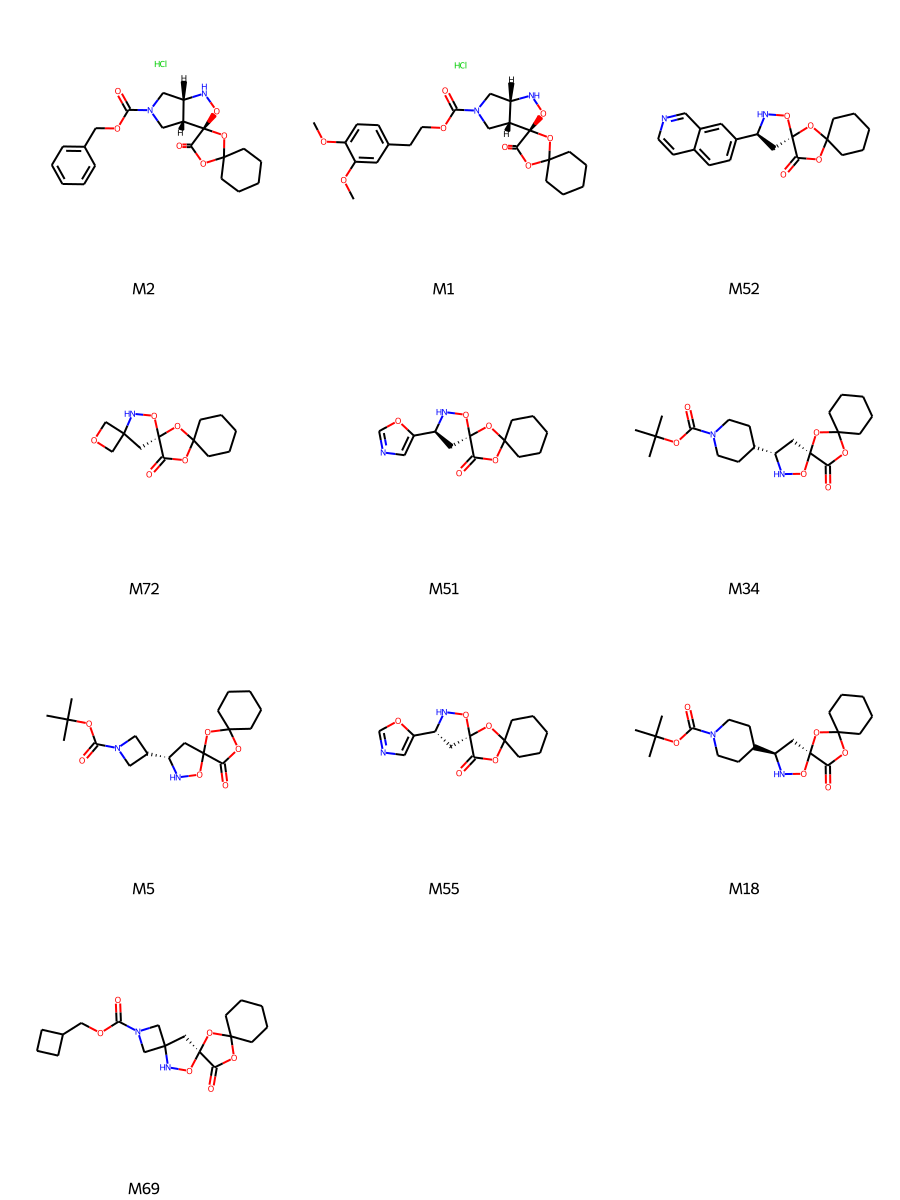

In [24]:
# let's look at these molecules
mols = []
for bb in x.head(10).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [25]:
x = df_full.loc[df_full['valid'].notna() & df_full['valid'].str.contains('multiple peaks for product A'), ['terminator']].value_counts()
x

terminator
T36           915
T34           837
T22           811
T38           781
T31           773
T32           754
T19           741
T23           717
T21           673
T33           630
T39           623
T20           618
T30           607
T29           607
T40           605
T28           603
T26           592
T25           572
T27           554
T35           534
T41           499
T1            400
T37           386
T17           354
T3            275
T12           252
T7            247
T24           226
T13           211
T2            199
T10           191
T6            165
T8            161
T16           155
T11           139
T4            130
T14           126
T15           121
T18           120
T5            101
T9              6
dtype: int64

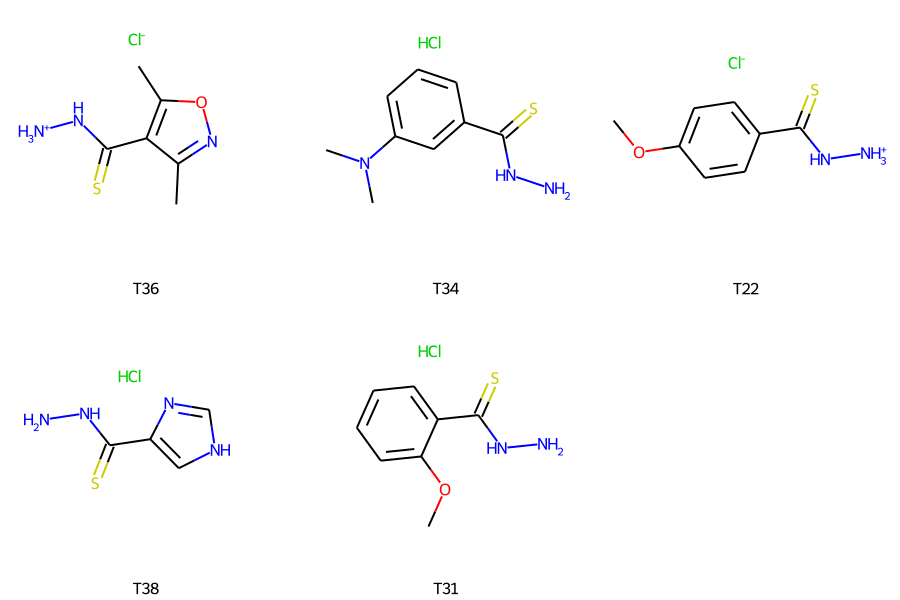

In [26]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

#### Remove invalid reactions
We move all entries containing "ERROR". Warnings can stay.

In [27]:
df = df_full.loc[~df_full.has_error]
print(f'Number of reactions after removing invalid entries: {len(df)}')

Number of reactions after removing invalid entries: 39857


In [28]:
df = df.loc[~df['product_A_lcms_ratio'].isna()]  # ensure all entries have a measured lcms ratio
print(f'Number of reactions after removing NaN entries: {len(df)}')

Number of reactions after removing NaN entries: 39857


Now we have a cleaned dataset (which may still contain a few duplicates). Let's try some basic statistics

How many reactions are successful (i.e. normalized lmcs ratio for A > threshold ?)

In [29]:
# add min-max normalized LC-MS responses (each column is normalized separately)
lcms_ratio_columns = [f'product_{s}_lcms_ratio' for s in "ABCDEFGH"]

df[[f'{s}_normalized' for s in "ABCDEFGH"]] = (
      df[lcms_ratio_columns] - df[lcms_ratio_columns].min()) / (df[lcms_ratio_columns].max() - df[lcms_ratio_columns].min()
)


In [30]:
# add information about reactant classes to df
def get_reaction_type_for_series(ser):
    new = []
    for i in ser:
        new.append(db.get_building_block_class(i))
    return pd.Series(data=new)
        
df[['initiator_type', 'monomer_type', 'terminator_type']] = df[['initiator', 'monomer', 'terminator']].apply(get_reaction_type_for_series, axis=1)
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,0.145169,0.004820,0.000000,0.010777,0.002577,0.142680,0.000278,KAT_arom,Mon_sub_3,TerTH
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,0.105225,0.004056,0.000000,0.001693,0.003760,0.148993,0.000000,KAT_arom,Mon_sub_3,TerTH
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,0.098541,0.000710,0.000000,0.000000,0.003233,0.146441,0.000000,KAT_arom,Mon_sub_3,TerTH
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,0.288984,0.001253,0.000020,0.007408,0.003557,0.172315,0.000205,KAT_arom,Mon_sub_3,TerTH
10584,5,4,A9,JG255,2021-08-17,I67,M20,T1,Ph023,Mon017,...,0.001331,0.000000,0.000038,0.005457,0.013340,0.189087,0.000778,KAT_arom,Mon_sub_3,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85516,4,3,P4,JG248,2021-07-15,I33,M22,T32,Al038,Mon020,...,0.046417,0.000831,0.020238,0.005780,0.001261,0.006278,0.000563,KAT_al,Mon_sub_3,TerTH
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,0.065822,0.004611,0.061600,0.068449,0.000842,0.009466,0.002621,KAT_al,Mon_sub_3,TerTH
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,0.021527,0.000000,0.010246,0.004161,0.002566,0.012481,0.000092,KAT_al,Mon_sub_3,TerTH


### General Statistics <a id=3></a>

Let's look at how well reactions have worked across the (cleaned) data set

In [31]:
df[[col for col in df.columns if 'lcms' in col]]

,product_A_lcms_ratio,product_B_lcms_ratio,product_C_lcms_ratio,product_D_lcms_ratio,product_E_lcms_ratio,product_F_lcms_ratio,product_G_lcms_ratio,product_H_lcms_ratio
id,,,,,,,,
10578,0.373249,0.273658,0.008525,0.000000,0.070392,0.066699,0.153381,0.006903
10579,0.058701,0.198360,0.007174,0.000000,0.011061,0.097328,0.160168,0.000000
10580,0.142968,0.185760,0.001255,0.000000,0.000000,0.083690,0.157424,0.000000
10581,0.328425,0.544764,0.002216,0.000620,0.048389,0.092084,0.185239,0.005079
10584,0.368615,0.002509,0.000000,0.001167,0.035644,0.345298,0.203269,0.019286
...,...,...,...,...,...,...,...,...
85516,0.066771,0.087501,0.001470,0.626071,0.037755,0.032651,0.006748,0.013956
85517,0.399229,0.124082,0.008156,1.905602,0.447089,0.021789,0.010175,0.064999
85518,0.029753,0.040580,0.000000,0.316965,0.027180,0.066432,0.013417,0.002293


In [32]:
for product_type in "ABCDEFGH":
    print(f'Number of reactions with any LC-MS signal for {product_type}: {len(df.loc[df[f"{product_type}_normalized"] > 0])} ({len(df.loc[df[f"{product_type}_normalized"] > 0]) / len(df):.1%})')
    for threshold in [1e-10, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
        t_and_f = (df[f"{product_type}_normalized"] > threshold).value_counts()
        print(f'This ratio of reactions is above the {threshold:.1} threshold: {t_and_f[True] / (t_and_f[True]+ t_and_f[False]):.1%}')

Number of reactions with any LC-MS signal for A: 32770 (82.2%)
This ratio of reactions is above the 1e-10 threshold: 82.2%
This ratio of reactions is above the 0.001 threshold: 73.9%
This ratio of reactions is above the 0.005 threshold: 57.6%
This ratio of reactions is above the 0.01 threshold: 48.5%
This ratio of reactions is above the 0.05 threshold: 21.8%
This ratio of reactions is above the 0.1 threshold: 10.4%
This ratio of reactions is above the 0.2 threshold: 3.4%
Number of reactions with any LC-MS signal for B: 23084 (57.9%)
This ratio of reactions is above the 1e-10 threshold: 57.9%
This ratio of reactions is above the 0.001 threshold: 49.8%
This ratio of reactions is above the 0.005 threshold: 39.1%
This ratio of reactions is above the 0.01 threshold: 34.5%
This ratio of reactions is above the 0.05 threshold: 19.6%
This ratio of reactions is above the 0.1 threshold: 10.3%
This ratio of reactions is above the 0.2 threshold: 3.0%
Number of reactions with any LC-MS signal for C:

For a graphical assessment, we plot the histograms for all normalized product yields

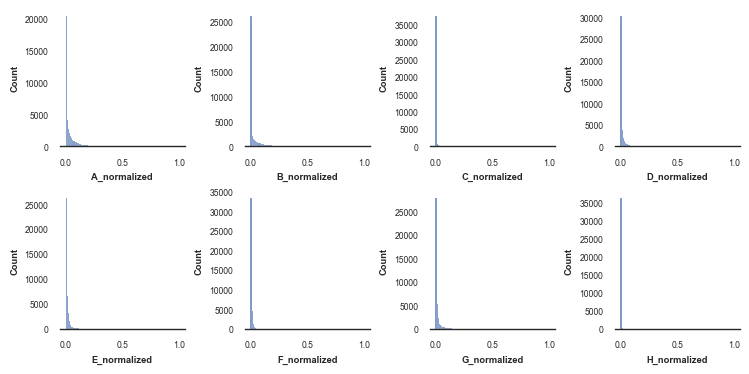

In [33]:
nbins = 100
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(7.5, 3.75))
sns.histplot(df['A_normalized'], bins=nbins, ax=axs[0][0])
sns.histplot(df['B_normalized'], bins=nbins, ax=axs[0][1])
sns.histplot(df['C_normalized'], bins=nbins, ax=axs[0][2])
sns.histplot(df['D_normalized'], bins=nbins, ax=axs[0][3])
sns.histplot(df['E_normalized'], bins=nbins, ax=axs[1][0])
sns.histplot(df['F_normalized'], bins=nbins, ax=axs[1][1])
sns.histplot(df['G_normalized'], bins=nbins, ax=axs[1][2])
sns.histplot(df['H_normalized'], bins=nbins, ax=axs[1][3])
fig.tight_layout()
fig.savefig(SAVE_DIR / 'normalized_lcms_histograms.png', dpi=300)

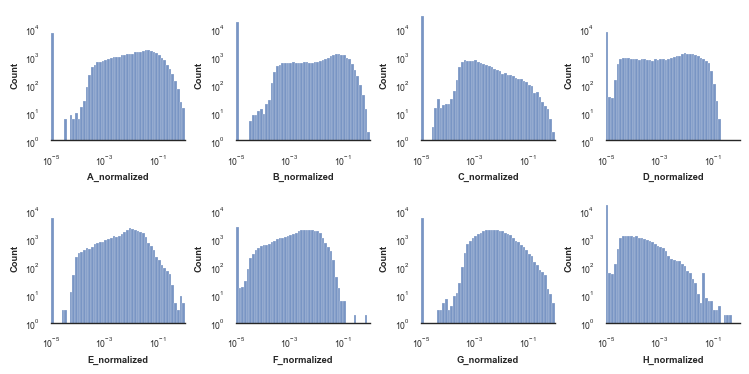

In [34]:
nbins = 50
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(7.5, 3.75))
sns.histplot(df['A_normalized'] + 1e-5, bins=nbins, ax=axs[0][0], log_scale=(True, True))
sns.histplot(df['B_normalized'] + 1e-5, bins=nbins, ax=axs[0][1], log_scale=(True, True))
sns.histplot(df['C_normalized'] + 1e-5, bins=nbins, ax=axs[0][2], log_scale=(True, True))
sns.histplot(df['D_normalized'] + 1e-5, bins=nbins, ax=axs[0][3], log_scale=(True, True))
sns.histplot(df['E_normalized'] + 1e-5, bins=nbins, ax=axs[1][0], log_scale=(True, True))
sns.histplot(df['F_normalized'] + 1e-5, bins=nbins, ax=axs[1][1], log_scale=(True, True))
sns.histplot(df['G_normalized'] + 1e-5, bins=nbins, ax=axs[1][2], log_scale=(True, True))
sns.histplot(df['H_normalized'] + 1e-5, bins=nbins, ax=axs[1][3], log_scale=(True, True))
for ax in axs.flatten():
    ax.set_xlim(1e-5, 1)
    ax.set_ylim(1, 5e4)
fig.tight_layout()
fig.savefig(SAVE_DIR / 'normalized_lcms_histograms_logscale.png', dpi=300)

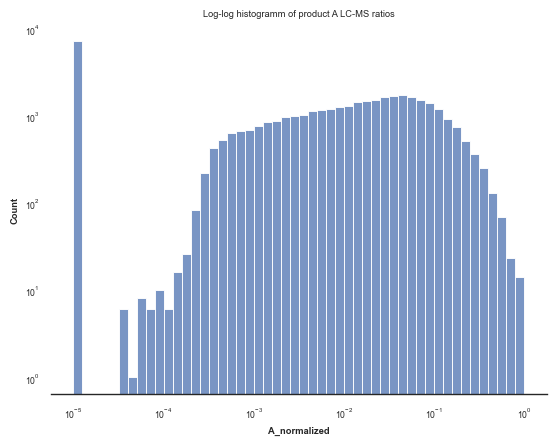

In [35]:
# let's see product A LC-MS response histogram with log axes
plt.figure()
sns.histplot(df['A_normalized'] + 1e-5, bins=50, log_scale=(True, True))  # +1e-5 to avoid log(0)=-inf
plt.title('Log-log histogramm of product A LC-MS ratios')
plt.savefig(SAVE_DIR / 'normalized_lcms_product-A_histogram_logscale.png', dpi=300)

<Figure size 640x480 with 0 Axes>

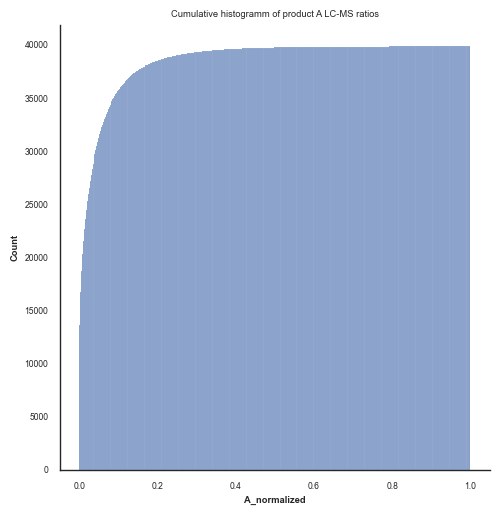

In [36]:
# let's see product A LC-MS response in a cumulative histogram
plt.figure()
sns.displot(df['A_normalized'], cumulative=True)
plt.title('Cumulative histogramm of product A LC-MS ratios')
plt.savefig(SAVE_DIR / 'normalized_lcms_product-A_cumulative_histogram.png', dpi=300)

<Figure size 640x480 with 0 Axes>

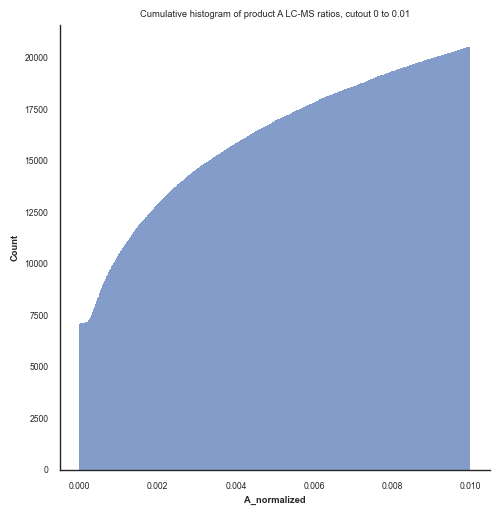

In [37]:
# let's enlarge the 0 to 1e-2 range
plt.figure()
sns.displot(df.loc[df["A_normalized"] < 0.01, 'A_normalized'], cumulative=True, bins=1000)
plt.title('Cumulative histogram of product A LC-MS ratios, cutout 0 to 0.01')
plt.savefig(SAVE_DIR / 'normalized_lcms_product-A_cumulative_histogram_cutout_0to1e-2.png', dpi=300)

<Figure size 640x480 with 0 Axes>

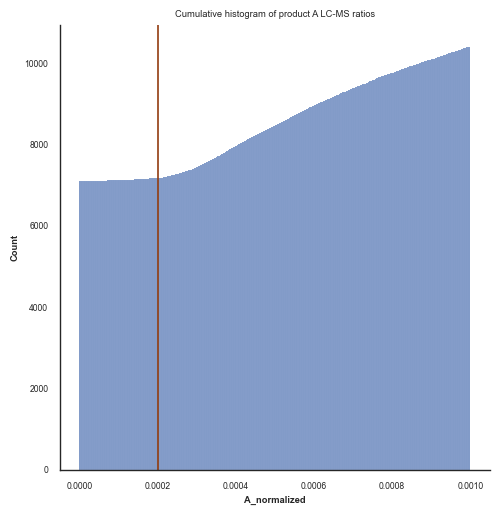

In [38]:
# let's enlarge the 0 to 1e-3 range
plt.figure()
sns.displot(df.loc[df["A_normalized"] < 0.001, 'A_normalized'], cumulative=True, bins=1000)
plt.title('Cumulative histogram of product A LC-MS ratios')
plt.axvline(x=0.0002, color=bode_palette.orange)
plt.show()

### Conclusion from LCMS threshold search
The LC-MS threshold can be set to 2e-4 for product A, as this is the point where the curve starts to flatten out. However, there are very few samples in this region, and it may not make sense to exclude them, particularly given that we already have noise filtering in the LC-MS peak picking step. It would make more sense to include everything >0 as positive, but use the lcms ratios for the other products to determine when only a meaningless amount of A is formed.

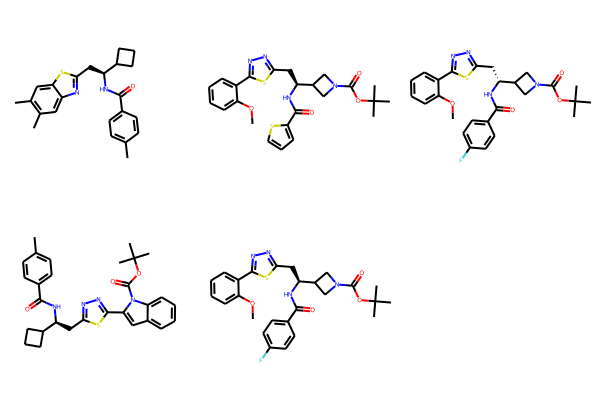

In [39]:
# Curious side question: What products have the highest lcms response for product A?

products = []
for vl_id in df.sort_values('A_normalized', ascending=False).head(5)['vl_id']:
    products.append(db.get_vl_member(vl_id))
[Compute2DCoords(p) for p in products]
Draw.MolsToGridImage(products)

### Building Block statistics <a id=4></a>

Let's look into details: __For each initator, how many reactions have worked above the threshold?__

In [40]:
THRESHOLD = 0  # response has to be bigger than this to be counted as success

In [41]:
# first add a success True/False column
for product in "ABCDEFGH":
    df[f"{product}_success"] = df[f"{product}_normalized"] > THRESHOLD

In [42]:
def calc_success_rate(df, column, product_type="A", sort_results=True):
    """
    Take a dataframe df, where for one column of interest, for each unique identifier in that column, the frequency
    of successful reactions (as indicated by the threshold) is calculated.
    :param df: pandas.DataFrame
    :param column: Column by which to group, e.g. monomer or monomer_type
    :param product_type: Which product to use for success rate calculation
    :return: pandas.DataFrame
    """
    # group by the column of interest
    grouped = df.groupby([column])
    # count positive + all examples and determine success rate
    n_all = grouped[f"{product_type}_success"].count().rename('n_all')
    n_success = grouped[f"{product_type}_success"].sum().rename('n_success')
    success_rates = (n_success / n_all).rename('success_rate')
    # assemble results
    df = pd.concat([n_all, n_success, success_rates], axis=1)
    df.index.name = "building_block"
    if sort_results is True:
        df = df.sort_index(
            #key=alphanumeric_index_sort
        )
    df = df.reset_index()
    return df

In [43]:
# obtain dictionary of building block classes from database
reactant_class = {f"I{i}": db.get_building_block_class(f"I{i}") for i in range(1, 79)}
reactant_class.update({f"M{i}": db.get_building_block_class(f"M{i}") for i in range(1, 75)})
reactant_class.update({f"T{i}": db.get_building_block_class(f"T{i}") for i in range(1, 42)})

# assign colors to the different classes for plotting
reactant_colors = {
    "KAT_hetarom": "blue",
    "KAT_arom": "lightblue",
    "KAT_al": "green",
    "Mon_fused": "blue",
    "Mon_spiro_2": "green",
    "Mon_spiro_3": "lightgreen",
    "Mon_sub_2": "red",
    "Mon_sub_3": "orange",
    "TerABT": "blue",
    "TerTH": "green",
}

building_block_colors = {k: reactant_colors[v] for k, v in reactant_class.items()}
#building_block_colors

In [44]:
# we calculate success rates for product A for all initiators
success_rates_by_initiator = calc_success_rate(df, 'initiator_long')
# let's do the same for monomers
success_rates_by_monomer = calc_success_rate(df, 'monomer_long')
# and the same for terminators
success_rates_by_terminator = calc_success_rate(df, 'terminator_long')

success_rates = pd.concat((success_rates_by_initiator, success_rates_by_monomer, success_rates_by_terminator))
print("Success rates:")
for _, i in success_rates.iterrows():
    print(f'{i["building_block"]}: {i["success_rate"]:.1%} ({i["n_success"]}/{i["n_all"]})')


Success rates:
2-Pyr003: 90.6% (510/563)
2-Pyr006: 82.1% (391/476)
2-Pyr007: 88.7% (448/505)
2-Pyr008: 85.1% (784/921)
2-Pyr009: 92.9% (932/1003)
2-Pyr010: 86.3% (446/517)
2-Thio001: 84.3% (499/592)
3-Fur001: 87.2% (830/952)
3-Pyr002: 81.9% (458/559)
3-Pyr003: 81.9% (412/503)
3-Pyr004: 80.5% (413/513)
3-Thio001: 84.2% (404/480)
4-Pym001: 87.4% (402/460)
4-Pyr002: 88.9% (870/979)
4-Pyrazole001: 83.3% (860/1033)
5-Quin001: 71.0% (346/487)
6-Quin001: 72.4% (336/464)
8-Quin003: 75.9% (186/245)
8-Quin004: 80.7% (753/933)
8-Quin005: 73.8% (228/309)
8-Quin008: 76.9% (226/294)
Al001: 87.8% (906/1032)
Al002: 79.5% (404/508)
Al003: 80.7% (502/622)
Al004: 70.1% (359/512)
Al005: 87.3% (419/480)
Al007: 78.5% (377/480)
Al013: 73.0% (340/466)
Al036: 80.7% (381/472)
Al038: 79.1% (382/483)
BiAl007: 85.0% (498/586)
BiAl008: 80.5% (289/359)
BiAl009: 80.6% (249/309)
BiPh001: 86.8% (524/604)
BiPh002: 91.3% (522/572)
BiPh004: 81.5% (446/547)
BiPh006: 81.2% (385/474)
BiPh007: 88.4% (851/963)
BiPh010: 87.0% (

In [45]:
def plot_success_count_by_building_block(success_rates, figsize=(4, 6), save_path=None):
    # show how many reactions are successful for each initiator
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, width_ratios=[3, 1])

    # plot a mean line
    axs[0].axvline(success_rates['success_rate'].mean(), ls='--', c='black')
    # plot the success rates
    sns.barplot(x=success_rates['success_rate'], y=success_rates['building_block'], ax=axs[0])
    # plot the number of experiments
    sns.barplot(x=success_rates['n_all'], y=success_rates['building_block'], ax=axs[1])

    # set details
    axs[0].set_xlabel(f'Ratio of successful reactions')
    axs[0].set_ylabel('Building block')
    axs[0].set_xlim(0,1)
    axs[1].set_xlabel('Number of reactions')
    axs[1].set_ylabel(None)
    axs[1].set_yticks([])
    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=300)
    return fig

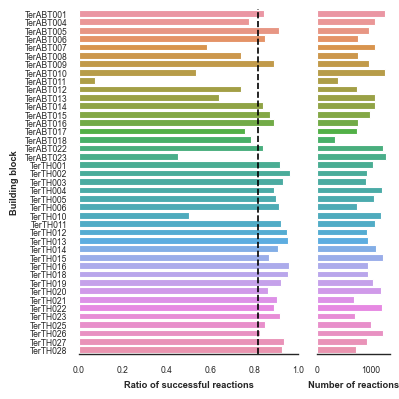

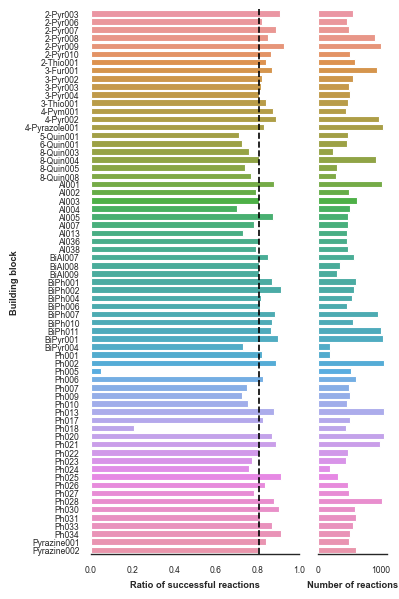

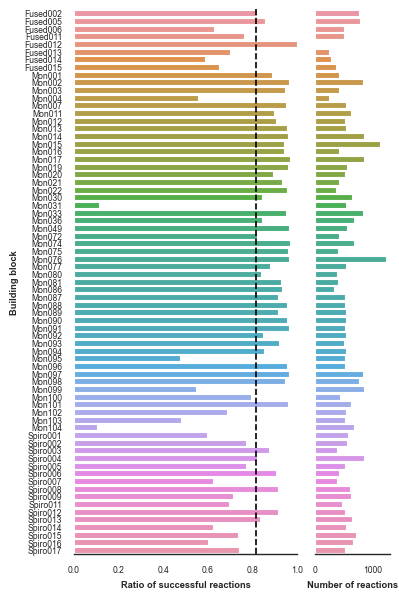

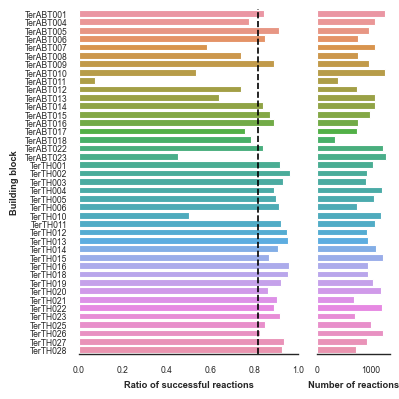

In [46]:
# save to file but don't show
plot_success_count_by_building_block(success_rates_by_initiator, save_path=SAVE_DIR / 'success_rates_by_initiator.png')
plot_success_count_by_building_block(success_rates_by_monomer, save_path=SAVE_DIR / 'success_rates_by_monomer.png')
plot_success_count_by_building_block(success_rates_by_terminator, save_path=SAVE_DIR / 'success_rates_by_terminator.png', figsize=(4, 4))

In [47]:
def plot_outcome_2D(df, x1, x2, y, product, building_block_colors=None, save_dir=SAVE_DIR):
    """Plot a 2D heatmap of the success rate of reactions for two building block types averaged over the third type"""
    # set up layout
    rel_width = (df[x1].nunique(), df[x2].nunique())
    rel_height = df[y].nunique() / (df[x1].nunique() + df[x2].nunique())
    fig, ax = plt.subplots(figsize=(18, 18* rel_height), ncols=2, width_ratios=rel_width)
    cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # [left, bottom, width, height]

    # prepare data
    df_heatmap1 = df.groupby([y, x1]).mean(numeric_only=True)[f"{product}_success"].unstack()
    df_heatmap1 = df_heatmap1.sort_index(key=alphanumeric_index_sort)
    df_heatmap1 = df_heatmap1.sort_index(key=alphanumeric_index_sort, axis=1)

    df_heatmap2 = df.groupby([y, x2]).mean(numeric_only=True)[f"{product}_success"].unstack()
    df_heatmap2 = df_heatmap2.sort_index(key=alphanumeric_index_sort)
    df_heatmap2 = df_heatmap2.sort_index(key=alphanumeric_index_sort, axis=1)

    # plot
    sns.heatmap(df_heatmap1, ax=ax[0],  cmap='viridis', vmin=0, vmax=1, center=0, linewidths=0.5, annot=False, fmt='.0%', cbar_ax=cbar_ax)
    sns.heatmap(df_heatmap2, ax=ax[1],  cmap='viridis', vmin=0, vmax=1, center=0, linewidths=0.5, annot=False, fmt='.0%', cbar=False, yticklabels=False)

    ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
    if building_block_colors:
        for axes in ax:
            # Set the x-axis tick label background colors for the first heatmap
            for label in axes.get_xticklabels():
                bbox = dict(boxstyle="round", fc=building_block_colors[label.get_text()], alpha=0.5)
                label.set_bbox(bbox)
            # Set the y-axis tick label background colors for the first heatmap
            for label in axes.get_yticklabels():
                bbox = dict(boxstyle="round", fc=building_block_colors[label.get_text()], alpha=0.5)
                label.set_bbox(bbox)

    ax[0].set_xlabel(x1.capitalize())
    ax[0].set_ylabel(y.capitalize())
    ax[1].set_xlabel(x2.capitalize())
    ax[1].set_ylabel(None)
    if save_dir:
        fig.savefig(save_dir / f"heatmap_{y}_product{product}.png", dpi=300, bbox_inches="tight")
    return fig


In [48]:
%%capture
# save to file but don't show
for product in "ABCDEFGH":
    plot_outcome_2D(df, "monomer", "terminator", "initiator", product, building_block_colors=building_block_colors)
    plot_outcome_2D(df, "initiator", "terminator", "monomer", product, building_block_colors=building_block_colors)
    plot_outcome_2D(df, "initiator", "monomer", "terminator", product, building_block_colors=building_block_colors)

### Trends within building block classes <a id=5></a>
Let's look at how well different types of initiators, monomers, terminators react

In [49]:
# let's check Initiators
success_rates_by_initiator_type = calc_success_rate(df, 'initiator_type', sort_results=False)
for _, i in success_rates_by_initiator_type.iterrows():
    print(f'Success rate for {i["building_block"]}: {i["success_rate"]:.1%} ({i["n_success"]}/{i["n_all"]})')

Success rate for KAT_al: 80.9% (5106/6309)
Success rate for KAT_arom: 81.2% (14938/18406)
Success rate for KAT_hetarom: 84.0% (12726/15142)


In [50]:
# let's check Monomers
success_rates_by_monomer_type = calc_success_rate(df, 'monomer_type', sort_results=False)
for _, i in success_rates_by_monomer_type.iterrows():
    print(f'Success rate for {i["building_block"]}: {i["success_rate"]:.1%} ({i["n_success"]}/{i["n_all"]})')

Success rate for Mon_fused: 74.7% (2574/3445)
Success rate for Mon_spiro_2: 83.7% (2799/3343)
Success rate for Mon_spiro_3: 70.9% (4017/5666)
Success rate for Mon_sub_2: 52.7% (2092/3969)
Success rate for Mon_sub_3: 90.8% (21288/23434)


In [51]:
# let's check Terminators
success_rates_by_terminator_type = calc_success_rate(df, 'terminator_type',  sort_results=False)
for _, i in success_rates_by_terminator_type.iterrows():
    print(f'Success rate for {i["building_block"]}: {i["success_rate"]:.1%} ({i["n_success"]}/{i["n_all"]})')

Success rate for TerABT: 73.3% (12320/16810)
Success rate for TerTH: 88.7% (20450/23047)


## Scaling the LCMS responses <a id=6></a>
- It seems to make sense to use some kind of robust scaling as we definitely expect outliers in LCMS data.
- We do not require centering, as the data starts at 0 and is not normally distributed.
- We could divide by the interquartile range (IQR) to get a robust scaling.
- We could also use the median absolute deviation (MAD) to get a robust scaling.
- However, both above ideas seem more suitable for symmetric distributions, while we have a highly skewed distribution with a defined minimum at 0.
- Therefore, we could just divide by, say, the 90th percentile to get the equivalent of min-max scaling but robust to outliers.
- Which percentile we choose, depends on the number of outliers we expect. The 90th percentile seems reasonable as we already remove internal standard errors and we can expect less than 10% of compounds to be outliers by virtue of ionizability alone. At the same time, choosing the 90th means we expect all products to form in at least 10% of the reactions.
- To not be dependent on how often a product forms: Use a lower (say 80th) percentile, but use only non-zero values in calculating the percentile.

### An extension to the scaling idea
Assume we have achieved robust scaling. There remains a problem:
- Consider product A systematically ionizes 10 times better than product B.
- Further, consider a reaction where we measure a non-zero response for product A that is at the lower detection limit
- It follows that we have no way to tell whether product B was formed or not, we only know it was not formed 10 times as much as A.

In general, if product A ionized better than product B by a factor of x, we need to see a response for product A exceeding the lower detection limit by a factor of x to conclude that product A is the major product.


In [52]:
def robust_scale(x: np.ndarray, percentile: int = 75, return_scaling_factor=False) -> Union[np.ndarray, Tuple[np.ndarray, float]]:
    """
    Robust scaling of a numpy array by dividing by the value for a percentile.
    The percentile is calculated from all non-zero values.
    """
    x = x.copy()
    scaling_factor = np.percentile(x[x > 0], percentile)
    x /= scaling_factor
    if return_scaling_factor:
        return x, scaling_factor
    else:
        return x

In [53]:
# before we apply scaling, we need to verify how sensitive the scaling is to our choice of the percentile.
factors = []
for percentile in range(1, 100):
    scaled_arrs = []
    scaling_factors = []
    for s in "ABCDEFGH":
        arr, factor = robust_scale(df[f'product_{s}_lcms_ratio'].values, percentile=percentile, return_scaling_factor=True)
        scaled_arrs.append(arr)
        scaling_factors.append(factor)
    factors.append(scaling_factors / scaling_factors[0])

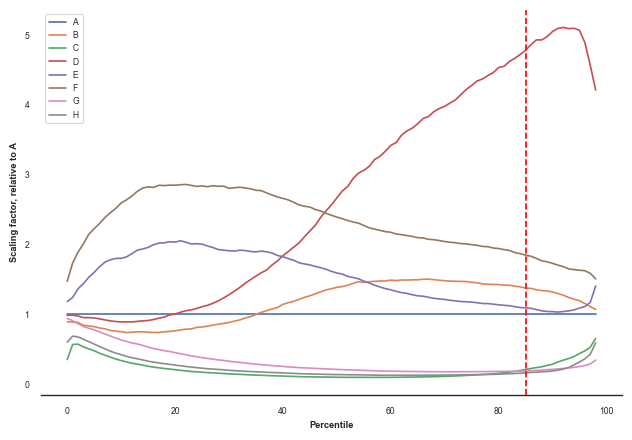

In [54]:
# plot the relative scaling factors for each product (A is always 1) for all percentiles between [1, 99]
plt.figure(figsize=(7.5,5))
plt.plot(factors)
plt.xlabel("Percentile")
plt.ylabel("Scaling factor, relative to A")
plt.axvline(85, color="red", linestyle="--", label="85th")
plt.legend("ABCDEFGH")
plt.savefig(SAVE_DIR / "scaling_factors_by_percentile.png", dpi=300)

### Result of the percentile/scaling factor analysis
This outcome is good. The range of the scaling factors is mostly 2x - 3x. This seems reasonable given that the molecules always share quite a few residues. Also, except product D, all relative factors are quite stable w.r.t. the choice of percentile. In particular, relative A,B,C are stable. As we expect, in the very high percentiles (>95 for most, >90 for E), the scaling factor becomes unstable as it is now dominated by outliers.

**Based on the plot, we choose the 85th percentile**

In [55]:
# apply scaling to all products and show scaling factors for control
scaling_factors = []
for s in "ABCDEFGH":
        arr, factor = robust_scale(df[f'product_{s}_lcms_ratio'].values, percentile=85, return_scaling_factor=True)
        df[f'{s}_scaled'] = arr
        scaling_factors.append(factor)
print("Scaling factors relative to A:")
for s, i in zip("ABCDEFGH", scaling_factors):
    print(f"{s}: {i/scaling_factors[0]:.1f}")

Scaling factors relative to A:
A: 1.0
B: 1.4
C: 0.2
D: 4.7
E: 1.1
F: 1.9
G: 0.2
H: 0.2


### Discussion of scaling factors
From the values of the scaling factors, products A, B, E, and  F ionize on a similar scale while product D ionizes 5x better and products C, G, and H ionize 5x worse.

Does this make sense bases on chemical intuition?
It's hard to predict ionization in MS, but the good ionization of D seems plausible as it is rather small and has a lot of polar groups. H is surprising because a similar argument could be made, but then again, H forms under very specific circumstances, so the side chain diversity is limited and that may bias the ionizability.

In [56]:
df[["A_scaled", "B_scaled", "C_scaled", "D_scaled", "E_scaled", "F_scaled", "G_scaled", "H_scaled"]].describe()

,A_scaled,B_scaled,C_scaled,D_scaled,E_scaled,F_scaled,G_scaled,H_scaled
count,39857.000000,39857.000000,39857.000000,39857.000000,39857.000000,39857.000000,39857.000000,36514.000000
mean,0.414983,0.267653,0.244064,0.371751,0.499797,0.469540,0.574644,0.667997
std,0.781755,0.562705,1.563590,0.759908,1.144996,0.997970,1.512304,9.123624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009792,0.000000,0.000000,0.001600,0.024379,0.040466,0.047474,0.000000
50%,0.101830,0.008523,0.000000,0.033214,0.194911,0.208884,0.159460,0.025076
75%,0.478311,0.278213,0.022714,0.386530,0.560065,0.607532,0.482711,0.184964
max,11.344593,8.791365,59.003008,42.547048,38.693192,89.997588,37.769362,1039.040294


## Outcome for the main product <a id=7></a>

In [57]:
# assign the main product
df["main_product"] = df[["A_scaled", "B_scaled", "C_scaled"]].idxmax(axis=1).str.replace("_scaled", "")
# are there any reactions where neither A,nor B, nor C appear?
df.loc[df[["A_scaled", "B_scaled", "C_scaled"]].sum(axis=1) == 0, "main_product"] = "none"
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,H_success,A_scaled,B_scaled,C_scaled,D_scaled,E_scaled,F_scaled,G_scaled,H_scaled,main_product
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,True,2.423119,1.276233,0.284406,0.000000,0.416990,0.231905,5.388926,0.289226,A
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,False,0.381088,0.925074,0.239307,0.000000,0.065524,0.338397,5.627388,0.000000,B
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,False,0.928141,0.866314,0.041880,0.000000,0.000000,0.290979,5.530973,0.000000,A
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,True,2.132121,2.540566,0.073934,0.000853,0.286648,0.320162,6.508240,0.212779,B
10584,5,4,A9,JG255,2021-08-17,I67,M20,T1,Ph023,Mon017,...,True,2.393033,0.011700,0.000000,0.001604,0.211149,1.200553,7.141696,0.808038,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85516,4,3,P4,JG248,2021-07-15,I33,M22,T32,Al038,Mon020,...,True,0.433472,0.408072,0.049038,0.861074,0.223657,0.113522,0.237100,0.584712,A
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,True,2.591782,0.578669,0.272085,2.620893,2.648494,0.075759,0.357507,2.723261,A
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,True,0.193155,0.189247,0.000000,0.435942,0.161010,0.230975,0.471399,0.096069,A


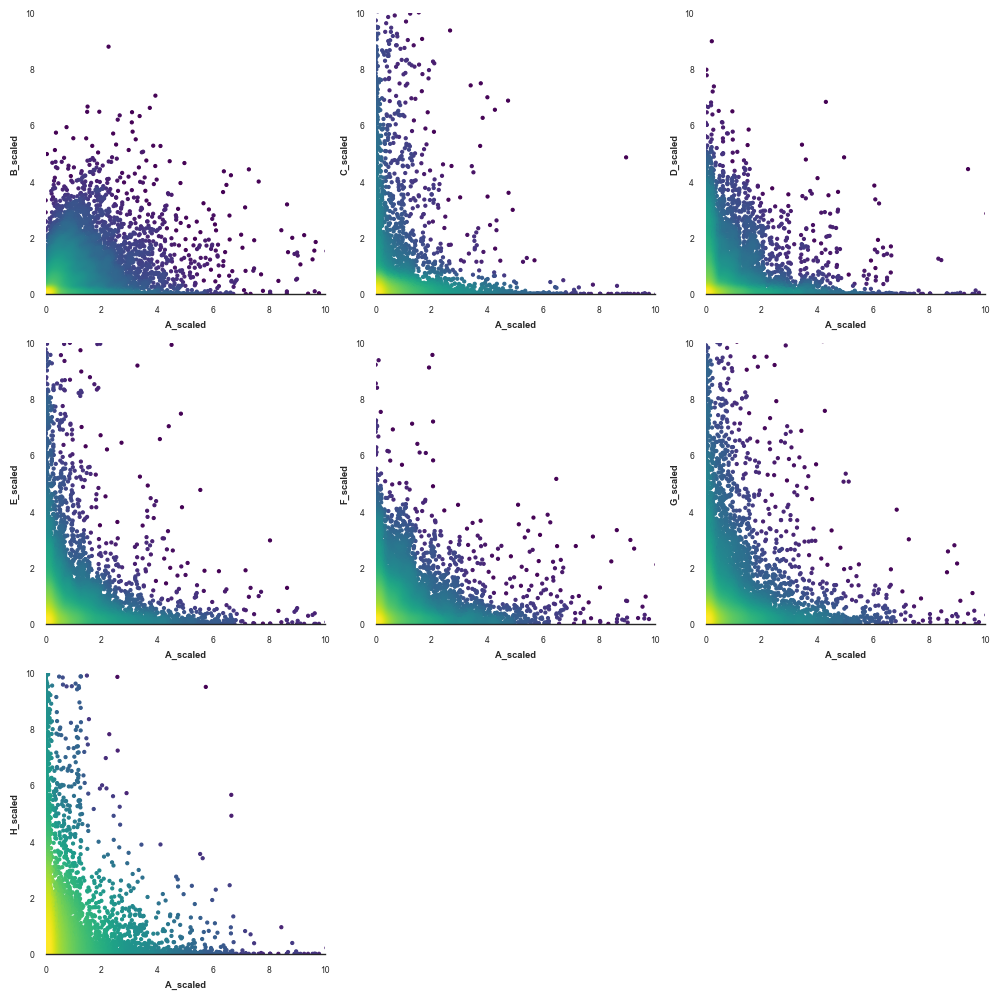

In [58]:
# how are the different success rates related?
# scatterplot between A_scaled and others
x = df["A_scaled"].values

fig, ax = plt.subplots(figsize=(10,10), ncols=3, nrows=3)
for i, s in enumerate("BCDEFGH"):
    row = i // 3
    col = i % 3
    y = np.nan_to_num(df[f"{s}_scaled"].values)
    # Calculate the point density
    xy = np.vstack([x,y])
    z = np.log10(gaussian_kde(xy)(xy))

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax[row, col].scatter(x, y, c=z, s=5, cmap="viridis")
    ax[row, col].set_xlabel('A_scaled')
    ax[row, col].set_ylabel(f'{s}_scaled')
    ax[row, col].set_xlim(0, 10)  # exclude outliers. We scaled the data to be able to compared them
    ax[row, col].set_ylim(0, 10)  # exclude outliers. We scaled the data to be able to compared them
# Hide the last two axes
ax[2, 1].set_visible(False)
ax[2, 2].set_visible(False)
plt.tight_layout()
plt.savefig(SAVE_DIR / 'LCMS_yields_scatter.png', dpi=300, bbox_inches='tight')

In [59]:
# among A,B,C, which is the major product?
def plot_main_product_2D(df, x1, x2, y, building_block_colors=None, save_dir=SAVE_DIR):
    """Plot a 2D heatmap of the success rate of reactions for two building block types averaged over the third type"""
    rel_width = (df[x1].nunique(), df[x2].nunique())
    rel_height = df[y].nunique() / (df[x1].nunique() + df[x2].nunique())
    fig, ax = plt.subplots(figsize=(14, 14 * rel_height), ncols=2, width_ratios=rel_width)
    cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.8])  # [left, bottom, width, height]
    df_heatmap1 = df.groupby([y, x1])["main_product"].describe()["top"].map({"A": 0, "B": 1, "C": 2, "none": 3}).unstack()
    df_heatmap1 = df_heatmap1.sort_index(key=alphanumeric_index_sort)
    df_heatmap1 = df_heatmap1.sort_index(key=alphanumeric_index_sort, axis=1)

    df_heatmap2 = df.groupby([y, x2])["main_product"].describe()["top"].map({"A": 0, "B": 1, "C": 2, "none": 3}).unstack()
    df_heatmap2 = df_heatmap2.sort_index(key=alphanumeric_index_sort)
    df_heatmap2 = df_heatmap2.sort_index(key=alphanumeric_index_sort, axis=1)

    # Plot the first heatmap
    sns.heatmap(df_heatmap1, ax=ax[0], cmap=sns.color_palette("colorblind", n_colors=4), linewidths=0.5, annot=False, fmt='.0%', cbar_ax=cbar_ax, xticklabels=True)

    # Plot the second heatmap
    sns.heatmap(df_heatmap2, ax=ax[1], cmap=sns.color_palette("colorblind", n_colors=4), linewidths=0.5, annot=False, fmt='.0%', cbar=False, xticklabels=True, yticklabels=False)
    
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
    ax[0].set_xlabel(ax[0].get_xlabel().capitalize())
    ax[0].set_ylabel(ax[0].get_ylabel().capitalize())
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_xlabel(ax[1].get_xlabel().capitalize())
    ax[1].set_ylabel(None)

    # Set the tick label background colors
    if building_block_colors:
        for axes in ax:
            for label in axes.get_xticklabels():
                bbox = dict(boxstyle="Round,pad=0.1", fc=building_block_colors[label.get_text()], alpha=0.5)
                label.set_bbox(bbox)
            # Set the y-axis tick label background colors for the first heatmap
            for label in axes.get_yticklabels():
                bbox = dict(boxstyle="Round,pad=0.1", fc=building_block_colors[label.get_text()], alpha=0.5)
                label.set_bbox(bbox)

    # change the colorbar labels to convey their meaning
    cbar_ax.set_ylabel("Main product")
    cbar_ax.yaxis.set_label_position("left")
    cbar_ax.set_yticks([i * 3 * 0.25 for i in (0.5, 1.5, 2.5, 3.5)], ["A", "B", "C", "none"], rotation=0)
    #cbar_ax.set_yticks([])  # for slides, remove the ticks
    cbar_ax.set_aspect(10)

    if save_dir:
        fig.savefig(save_dir / f"heatmap_{y}_main_product.png", dpi=300, bbox_inches="tight")
    return fig

In [60]:
%%capture
plot_main_product_2D(df, "monomer", "terminator", "initiator", building_block_colors=building_block_colors)
plot_main_product_2D(df, "initiator", "terminator", "monomer", building_block_colors=building_block_colors)
plot_main_product_2D(df, "initiator", "monomer", "terminator", building_block_colors=building_block_colors)

### Plot with relative success rates
The plots above exclude some information because they only show the most successful product. We can also plot the relative success rates of the different products.

In [61]:
grouped = df.groupby(["initiator", "monomer"])
all_count = grouped["main_product"].count()
a_ratio = grouped["main_product"].sum().str.count("A") / all_count
b_ratio = grouped["main_product"].sum().str.count("B") / all_count
c_ratio = grouped["main_product"].sum().str.count("C") / all_count
none_ratio = grouped["main_product"].sum().str.count("none") / all_count
relative_products = pd.concat((a_ratio, b_ratio, c_ratio, 1 - none_ratio), axis=1, ignore_index=True)  # we do 1 - none_ratio because we will use that for alpha
relative_products = relative_products.unstack()
relative_products = relative_products.sort_index(key=alphanumeric_index_sort)
relative_products = relative_products.sort_index(key=alphanumeric_index_sort, axis=1, level=1, sort_remaining=False)
arr = relative_products.to_numpy()
heatmap_arr = arr.reshape((len(relative_products.index.get_level_values(0).unique()), len(relative_products.columns.get_level_values(1).unique()), 4), order="C")
heatmap_arr

array([[[0.4       , 0.4       , 0.        , 0.8       ],
        [0.4       , 0.5       , 0.        , 0.9       ],
        [0.85714286, 0.        , 0.        , 0.85714286],
        ...,
        [0.125     , 0.875     , 0.        , 1.        ],
        [0.88888889, 0.11111111, 0.        , 1.        ],
        [1.        , 0.        , 0.        , 1.        ]],

       [[0.54166667, 0.375     , 0.        , 0.91666667],
        [0.57142857, 0.38095238, 0.        , 0.95238095],
        [0.77777778, 0.        , 0.22222222, 1.        ],
        ...,
        [0.        , 0.70833333, 0.29166667, 1.        ],
        [0.05882353, 0.05882353, 0.76470588, 0.88235294],
        [0.22222222, 0.        , 0.66666667, 0.88888889]],

       [[0.5       , 0.3       , 0.        , 0.8       ],
        [0.88888889, 0.11111111, 0.        , 1.        ],
        [0.52941176, 0.05882353, 0.05882353, 0.64705882],
        ...,
        [       nan,        nan,        nan,        nan],
        [       nan,        n

/var/folders/bw/f4bnnf4n0c94qdgp8y3gvxsc0000gn/T/ipykernel_96289/237746863.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/Users/julian/miniconda3/envs/library-generation/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


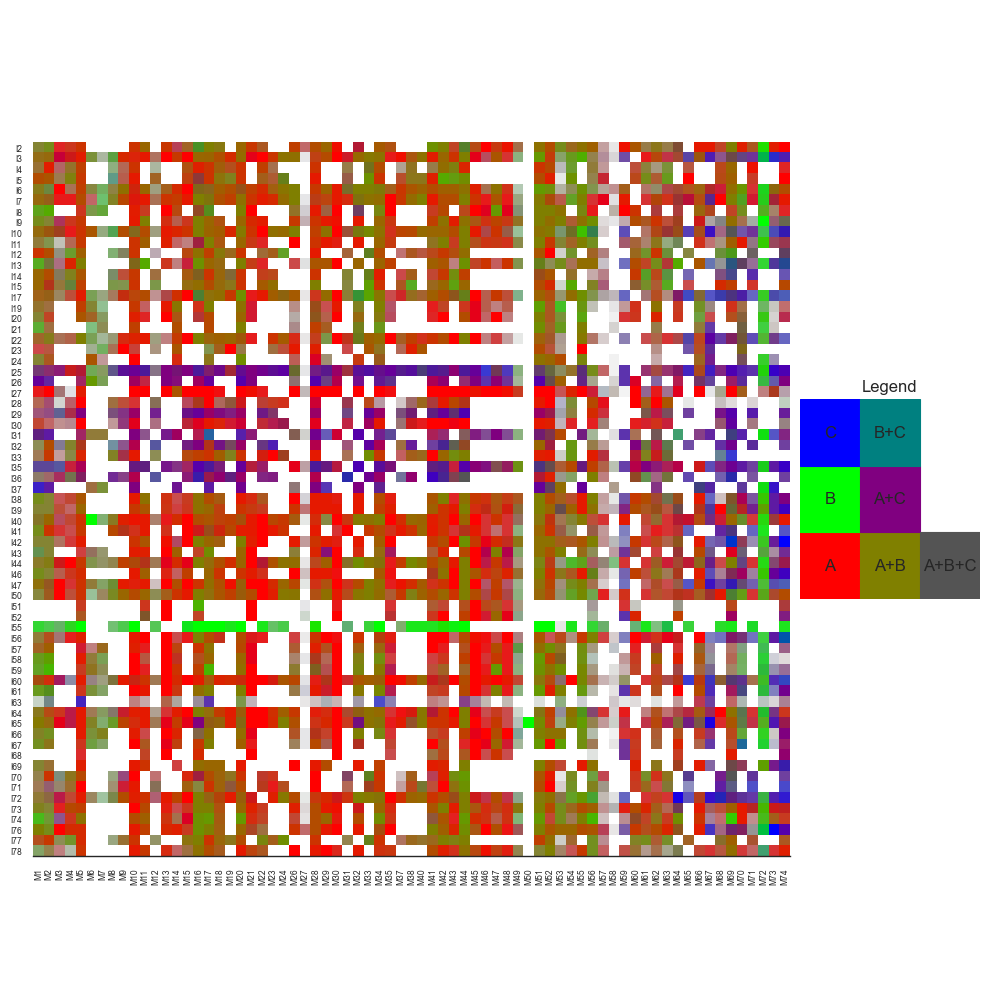

In [62]:
fig, ax = plt.subplots(figsize=(10,10), ncols=2, width_ratios=(.8, .2))
ax[1].axis("off")
ax = ax[0]
legend_ax = fig.add_axes([0.8, 0.4, 0.18, 0.2])  # [left, bottom, width, height]
im = ax.imshow(heatmap_arr, interpolation='nearest')
ax.set_xticks(np.arange(heatmap_arr.shape[1]), labels=relative_products.columns.get_level_values(1).unique(), rotation=90)
ax.set_yticks(np.arange(heatmap_arr.shape[0]), labels=relative_products.index)

legend_ax.add_patch(Rectangle((0, 0), .1, .1, color=(1,0,0,1)))
legend_ax.text(0.05, 0.05, "A", fontsize=12, ha="center", va="center")
legend_ax.add_patch(Rectangle((0, .1), .1, .1, color=(0,1,0,1)))
legend_ax.text(0.05, 0.15, "B", fontsize=12, ha="center", va="center")
legend_ax.add_patch(Rectangle((0, .2), .1, .1, color=(0,0,1,1)))
legend_ax.text(0.05, 0.25, "C", fontsize=12, ha="center", va="center")

legend_ax.add_patch(Rectangle((.1, 0), .1, .1, color=(.5,.5,0,1)))
legend_ax.text(0.15, 0.05, "A+B", fontsize=12, ha="center", va="center")
legend_ax.add_patch(Rectangle((.1, .1), .1, .1, color=(.5,0,.5,1)))
legend_ax.text(0.15, 0.15, "A+C", fontsize=12, ha="center", va="center")
legend_ax.add_patch(Rectangle((.1, .2), .1, .1, color=(0,.5,.5,1)))
legend_ax.text(0.15, 0.25, "B+C", fontsize=12, ha="center", va="center")

legend_ax.add_patch(Rectangle((.2, .0), .1, .1, color=(.33,.33,.33,1)))
legend_ax.text(0.25, 0.05, "A+B+C", fontsize=12, ha="center", va="center")
legend_ax.set_xlim(0, 0.3)
legend_ax.set_ylim(0, 0.3)
legend_ax.axis("off")
legend_ax.set_title("Legend", fontsize=12)
fig.tight_layout()
fig.savefig(SAVE_DIR / "heatmap_IM_relative_success.png", dpi=300, bbox_inches="tight")

In [63]:
# Can we plot the same information better by using tiny pie charts as the heatmap?
def heatmap_with_pies(ax, data_array, row_labels, column_labels, cmap=None, norm=None, building_block_colors=None):

    pies=[]
    # generate all the individual pies
    for row_index, row in enumerate(row_labels):
        for column_index, column in enumerate(column_labels):
            data_slice = data_array[row_index, column_index]
            radius = .4 * data_slice[:3].sum() +.05
            if np.isnan(data_slice).any():
                # if there are nan value, we have not conducted this reaction, so we plot nothing
                continue
            if data_slice.sum() == 0:
                # if there are no products found, we plot a black circle
                wedges, _ = plt.pie((1,), center=(column_index, row_index), radius=radius, colors=("black",), wedgeprops={"linewidth": 0})
            else:
                wedges, _ = plt.pie(data_slice, center=(column_index, row_index), radius=radius, colors=sns.color_palette("colorblind", n_colors=4), wedgeprops={"linewidth": 0}, startangle=270)

    col = PatchCollection(pies, array=data_array.flatten(), cmap=cmap, norm=norm)

    ax.add_collection(col)

    ax.set_xticks(np.arange(data_array.shape[1]), labels=column_labels, rotation=90)
    ax.set_yticks(np.arange(data_array.shape[0]), labels=row_labels)

    # we invert the y-axis (so that the first building block will be at the top)
    ax.invert_yaxis()

    # put a legend, based only on the last wedges (faster than automatic detection)
    ax.legend(wedges, ("A", "B", "C", "none"), loc="upper left", bbox_to_anchor=(1, 1), title="Products")

    # Set the tick label background colors
    if building_block_colors:
        for label in ax.get_xticklabels():
            bbox = dict(boxstyle="round", fc=building_block_colors[label.get_text()], alpha=0.5)
            label.set_bbox(bbox)
        # Set the y-axis tick label background colors for the first heatmap
        for label in ax.get_yticklabels():
            bbox = dict(boxstyle="round", fc=building_block_colors[label.get_text()], alpha=0.5)
            label.set_bbox(bbox)

    return ax

In [64]:
%%capture
# plot for initiator and monomer
data_array=heatmap_arr.copy()
data_array[:,:,3] = 1 - data_array[:,:,3]  # we need the success rate not the failure rate
row_labels=relative_products.index
column_labels=relative_products.columns.get_level_values(1).unique()

fig, ax = plt.subplots(figsize=(11, 10))
heatmap_with_pies(ax, data_array, row_labels, column_labels, building_block_colors=building_block_colors)
ax.set_xlabel("Monomer")
ax.set_ylabel("Initiator")

plt.tight_layout()
plt.savefig(SAVE_DIR / "heatmap_IM_relative_success_pies.png", dpi=300, bbox_inches="tight")

In [65]:
# prepare data for initiator and terminator
grouped = df.groupby(["initiator", "terminator"])
all_count = grouped["main_product"].count()
a_ratio = grouped["main_product"].sum().str.count("A") / all_count
b_ratio = grouped["main_product"].sum().str.count("B") / all_count
c_ratio = grouped["main_product"].sum().str.count("C") / all_count
none_ratio = grouped["main_product"].sum().str.count("none") / all_count
relative_products = pd.concat((a_ratio, b_ratio, c_ratio, 1 - none_ratio), axis=1, ignore_index=True)  # we do 1 - none_ratio because we will use that for alpha
relative_products = relative_products.unstack()
relative_products = relative_products.sort_index(key=alphanumeric_index_sort)
relative_products = relative_products.sort_index(key=alphanumeric_index_sort, axis=1, level=1, sort_remaining=False)
arr = relative_products.to_numpy()
heatmap_arr = arr.reshape((len(relative_products.index.get_level_values(0).unique()), len(relative_products.columns.get_level_values(1).unique()), 4), order="C")
heatmap_arr

array([[[       nan,        nan,        nan,        nan],
        [0.93548387, 0.        , 0.        , 0.93548387],
        [1.        , 0.        , 0.        , 1.        ],
        ...,
        [       nan,        nan,        nan,        nan],
        [0.33333333, 0.55555556, 0.11111111, 1.        ],
        [0.52941176, 0.47058824, 0.        , 1.        ]],

       [[0.85714286, 0.02857143, 0.02857143, 0.91428571],
        [0.61904762, 0.        , 0.0952381 , 0.71428571],
        [0.84615385, 0.02564103, 0.1025641 , 0.97435897],
        ...,
        [0.36666667, 0.46666667, 0.1       , 0.93333333],
        [0.29545455, 0.52272727, 0.15909091, 0.97727273],
        [0.33333333, 0.66666667, 0.        , 1.        ]],

       [[0.75      , 0.        , 0.        , 0.75      ],
        [1.        , 0.        , 0.        , 1.        ],
        [0.91666667, 0.        , 0.        , 0.91666667],
        ...,
        [0.66666667, 0.33333333, 0.        , 1.        ],
        [0.2       , 0.7     

In [66]:
%%capture
# plot for initiator and terminator
data_array=heatmap_arr.copy()
data_array[:,:,3] = 1 - data_array[:,:,3]  # we need the success rate not the failure rate
row_labels=relative_products.index
column_labels=relative_products.columns.get_level_values(1).unique()

fig, ax = plt.subplots(figsize=(11, 10))
heatmap_with_pies(ax, data_array, row_labels, column_labels, building_block_colors=building_block_colors)
ax.set_xlabel("Terminator")
ax.set_ylabel("Initiator")

plt.tight_layout()
plt.savefig(SAVE_DIR / "heatmap_IT_relative_success_pies.png", dpi=300, bbox_inches="tight")

In [67]:
# prepare data for monomer and terminator
grouped = df.groupby(["monomer", "terminator"])
all_count = grouped["main_product"].count()
a_ratio = grouped["main_product"].sum().str.count("A") / all_count
b_ratio = grouped["main_product"].sum().str.count("B") / all_count
c_ratio = grouped["main_product"].sum().str.count("C") / all_count
none_ratio = grouped["main_product"].sum().str.count("none") / all_count
relative_products = pd.concat((a_ratio, b_ratio, c_ratio, 1 - none_ratio), axis=1, ignore_index=True)  # we do 1 - none_ratio because we will use that for alpha
relative_products = relative_products.unstack()
relative_products = relative_products.sort_index(key=alphanumeric_index_sort)
relative_products = relative_products.sort_index(key=alphanumeric_index_sort, axis=1, level=1, sort_remaining=False)
arr = relative_products.to_numpy()
heatmap_arr = arr.reshape((len(relative_products.index.get_level_values(0).unique()), len(relative_products.columns.get_level_values(1).unique()), 4), order="C")
heatmap_arr

array([[[0.92307692, 0.        , 0.03846154, 0.96153846],
        [0.9375    , 0.        , 0.        , 0.9375    ],
        [1.        , 0.        , 0.        , 1.        ],
        ...,
        [0.04347826, 0.73913043, 0.17391304, 0.95652174],
        [0.        , 0.91666667, 0.08333333, 1.        ],
        [0.08333333, 0.83333333, 0.08333333, 1.        ]],

       [[0.88461538, 0.03846154, 0.07692308, 1.        ],
        [0.9375    , 0.        , 0.        , 0.9375    ],
        [1.        , 0.        , 0.        , 1.        ],
        ...,
        [0.30769231, 0.5       , 0.19230769, 1.        ],
        [0.36363636, 0.45454545, 0.18181818, 1.        ],
        [0.24      , 0.64      , 0.12      , 1.        ]],

       [[0.5       , 0.11538462, 0.11538462, 0.73076923],
        [       nan,        nan,        nan,        nan],
        [0.45454545, 0.09090909, 0.09090909, 0.63636364],
        ...,
        [0.42307692, 0.07692308, 0.07692308, 0.57692308],
        [0.25      , 0.416666

In [68]:
%%capture
# plot for monomer and terminator
data_array=heatmap_arr.copy()
data_array[:,:,3] = 1 - data_array[:,:,3]  # we need the success rate not the failure rate
row_labels=relative_products.index
column_labels=relative_products.columns.get_level_values(1).unique()

fig, ax = plt.subplots(figsize=(11, 10))
heatmap_with_pies(ax, data_array, row_labels, column_labels, building_block_colors=building_block_colors)
ax.set_xlabel("Terminator")
ax.set_ylabel("Monomer")

plt.tight_layout()
plt.savefig(SAVE_DIR / "heatmap_MT_relative_success_pies.png", dpi=300, bbox_inches="tight")

## Outcomes for repeated reactions
We ended up creating some duplicate reactions (divergence from the original duplicate-free plan became necessary when we ran out of some building blocks). Let's check how well they reproduce.

In [69]:
duplicated = df.loc[df.duplicated(subset=["long_name"], keep=False)]

In [70]:
# number of duplicated reactions
grouped_duplicates = duplicated.groupby("long_name")
len(grouped_duplicates)

371

In [71]:
grouped_duplicates_unstacked = grouped_duplicates["A_scaled"].apply(lambda x: pd.Series(x.values)).unstack()
grouped_duplicates_unstacked

,0,1
long_name,,
2-Pyr003 + Mon076 + TerABT004,0.688264,0.800188
2-Pyr003 + Mon076 + TerABT007,0.085746,0.153289
2-Pyr003 + Mon076 + TerABT013,0.050823,0.068567
2-Pyr003 + Mon076 + TerABT014,0.570417,0.845400
2-Pyr003 + Mon076 + TerTH001,0.910885,2.446620
...,...,...
Pyrazine002 + Mon076 + TerTH005,0.144597,0.180825
Pyrazine002 + Mon076 + TerTH011,0.260052,0.336743
Pyrazine002 + Mon076 + TerTH014,0.142122,0.210165


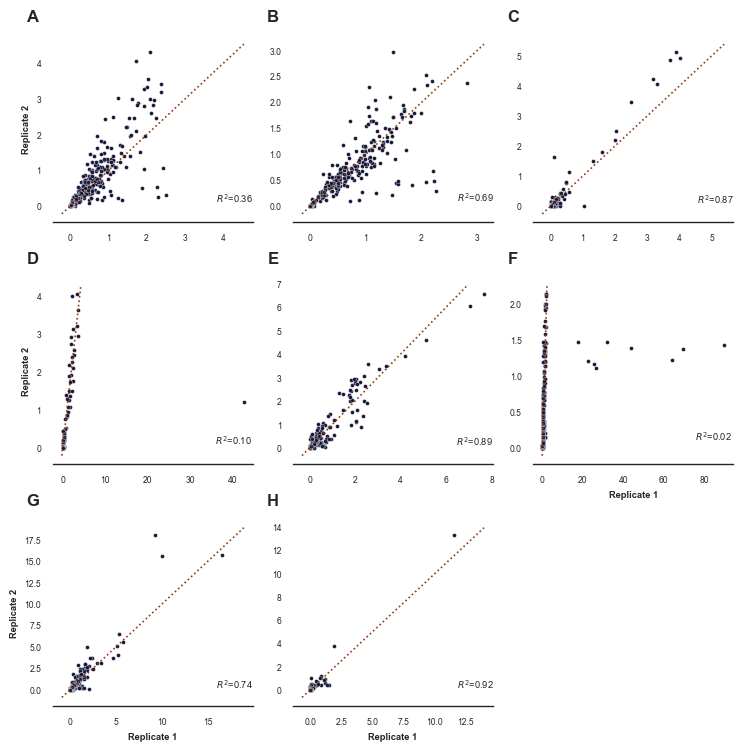

In [72]:
fig, ax = plt.subplots(figsize=(7.5, 7.5), nrows=3, ncols=3)
fig.subplots_adjust(left=0.15)
product_data = []  # we will want to re-use the data later, so we catch it here
for i, s in enumerate("ABCDEFGH"):
    row = i // 3
    col = i % 3
    
    # extract data
    data = grouped_duplicates[f"{s}_scaled"].apply(lambda x: pd.Series(x.values)).unstack()
    product_data.append(data)  # not used for plotting, just later re-use
    
    # plot data
    ax[row, col] = sns.scatterplot(data=data, x=0, y=1, ax=ax[row, col], s=8, color=bode_palette.blue)
    # plot diagonal (in data coords)
    ax[row, col].plot(ax[row, col].get_ylim(), ax[row,col].get_ylim(), c=bode_palette.orange, ls=":")
    # plot R2 score
    ax[row, col].text(x=(ax[row, col].get_xlim()[1] * .8), y=.1, s=f"$R^2$={r2_score(data[0], data[1]):.2f}")
    # plot a label for the axes
    ax[row, col].text(x=-0.1, y=1.1, s=s, fontsize=12, fontweight="bold", ha="center", va="center", transform=ax[row,col].transAxes)
    
    # set axis labels
    if col == 0:
        ax[row, col].set_ylabel("Replicate 2")
    else:
        ax[row, col].set_ylabel(None)
    if row == 2:
        ax[row, col].set_xlabel("Replicate 1")
    else:
        ax[row, col].set_xlabel(None)
    
ax[2, 2].set_visible(False)
ax[1, 2].set_xlabel("Replicate 1")
fig.tight_layout()
fig.savefig(SAVE_DIR / "replicates_scaled_responses_scatter.png", dpi=300)

In [73]:
# at a specific threshold for binning into positive and negative class, how often do the labels have the same class?
accuracies = []
for s, data in zip("ABCDEFGH", product_data):
    accuracy = accuracy_score((data > 0)[0], (data > 0)[1])
    accuracies.append(accuracy)
    print(f"Product {s}: {accuracy:.2f}")

Product A: 0.99
Product B: 0.93
Product C: 0.88
Product D: 0.85
Product E: 0.94
Product F: 0.99
Product G: 0.90
Product H: 0.76


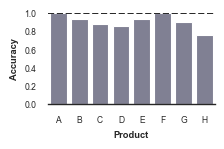

In [74]:
# plot this in a bar plot
fig, ax = plt.subplots(figsize=(2.25, 1.5))
sns.barplot(x=list("ABCDEFGH"), y=accuracies, ax=ax, color=bode_palette.blues[2])
ax.axhline(1, ls="--", c="black")
ax.set_xlabel("Product")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,1)
fig.tight_layout()
fig.savefig(SAVE_DIR / "replicates_binned_accuracies.png", dpi=300)

In [75]:
grouped_main_products = grouped_duplicates["main_product"].apply(lambda x: pd.Series(x.values)).unstack()

In [76]:
conf_mat = confusion_matrix(grouped_main_products[0], grouped_main_products[1])
conf_mat

array([[158,   3,   1,   0],
       [ 35, 145,   0,   0],
       [  3,   1,  15,   2],
       [  2,   0,   0,   6]])

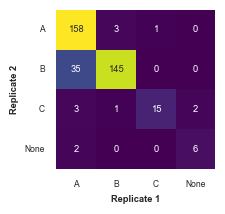

In [77]:
fig, ax = plt.subplots(figsize=(2.25, 2.25))
axislabels = ["A", "B", "C", "None"]
ax = sns.heatmap(conf_mat, cmap="viridis", annot=True, fmt="d", xticklabels=axislabels, yticklabels=axislabels, ax=ax, cbar=False)
ax.set_xlabel("Replicate 1")
ax.set_ylabel("Replicate 2")
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
ax.set_aspect(1)
fig.tight_layout()
fig.savefig(SAVE_DIR / "replicates_confusion_matrix.png", dpi=300)

In [78]:
balanced_accuracy_score(grouped_main_products[0], grouped_main_products[1])  # nb, this is average (macro) recall

0.8112874779541447

In [79]:
recall_score(grouped_main_products[0], grouped_main_products[1], average="weighted")

0.8733153638814016